# Masterarbeit (Batch-Tool)

In [1]:
# Tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Urls
from urllib.parse import urlparse
from collections import Counter

#Use notebook for interactive plots
#%matplotlib notebook
%matplotlib inline

In [2]:
# JSON Lib
! pip install demjson
import demjson

In [3]:
# Natural Language Toolkit
! pip install nltk
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# WordCloud
! pip install wordcloud
from wordcloud import WordCloud

In [5]:
# Show all columns
pd.set_option('display.max_columns', None)

In [6]:
# Dateien ausgeben und Variablen setzen
dir_var = "../"
! ls -al ../

total 52
drwxrwxr-x  6 jovyan  1000  4096 Dec 13 13:05 .
drwsrwsr-x  1 jovyan users  4096 Dec 13 12:59 ..
drwxrwxr-x 33 jovyan  1000  4096 Dec 13 13:05 DS-08-10-2020
drwxrwxr-x 18 jovyan  1000  4096 Dec 13 13:05 DS-22-10-2020
drwxrwxr-x  9 jovyan  1000  4096 Dec 13 15:34 .git
-rw-rw-r--  1 jovyan  1000    43 Dec 13 13:05 .gitattributes
-rw-rw-r--  1 jovyan  1000    30 Dec 13 13:05 .gitignore
-rw-rw-r--  1 jovyan  1000 11357 Dec 13 13:05 LICENSE
drwxrwxr-x  3 jovyan  1000  4096 Dec 13 15:34 notebooks
-rw-rw-r--  1 jovyan  1000   172 Dec 13 13:05 README.md


## Process jobs

In [7]:
dfInputFiles = pd.read_excel(dir_var + "notebooks/inputFiles.xlsx", header=None, names=["inputName", "inputPath", "inputType", "inputId"])

### !!!!!!!!!!!!!!!! Quick Filter !!!!!!!!!!!!!!!!!!!!

In [8]:
# Take only samples
#dfInputFiles = dfInputFiles.tail(45)
#dfInputFiles = dfInputFiles.head(1)
#dfInputFiles = dfInputFiles[dfInputFiles.inputName.str.contains("FREIHEIT")]

### Overview jobs

In [9]:
dfInputFiles

,inputName,inputPath,inputType,inputId
0,FREIHEITS-CHAT,DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat,public_supergroup,9717909816
1,Oliver Janich öffentlich,DS-08-10-2020/ChatExport_2020-09-25-janich,public_channel,9808932799
2,ATTILA HILDMANN OFFICIAL ⚫️⚪️🔴⚔️,DS-08-10-2020/ChatExport_2020-09-25-hildmann,public_channel,10034163583
3,Gerechtigkeit für das Vaterland,DS-08-10-2020/ChatExport_2020-09-26-gerechtigk...,public_channel,10069007089
4,Corona Virus Informationen,DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo,public_channel,9917074801
5,Liberté,DS-08-10-2020/ChatExport_2020-09-26-liberte,public_channel,10068807626
6,ॐ Golden Age Network ॐ,DS-08-10-2020/ChatExport_2020-09-26-goldenage,public_channel,9862302472
7,💙 Weltfrieden 2020 💙,DS-08-10-2020/ChatExport_2020-09-26-weltfriede...,public_channel,9850980068
8,🌍 Verschwörungen 🌍,DS-08-10-2020/ChatExport_2020-09-26-verschwoer...,public_channel,9942502804
9,[Q] Digital Research Army,DS-08-10-2020/ChatExport_2020-09-27-digitalRes...,public_channel,9846664545


### Transform jobs

In [10]:
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + filePath + "/result.json", encoding='utf-8')
    return dF

In [11]:
def convertToDataFrameMessages(filePath, dictMeta):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

In [12]:
def checkIsFormattedText(text):
    textString = str(text)
    if(textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    else:
        return False

In [13]:
# See below
def getExtractedParam(param, processedTextData):
    a,b,c,d,e,f,g = processedTextData
    switcher = {
        0: a,
        1: b,
        2: c,
        3: d,
        4: e,
        5: f,
        6: g
    }
    return switcher.get(param)

In [14]:
# TODO: What href in normal text?

# Return types (see above)

# a = processedText
# b = Items 'processedURLs'
# c = Items 'processedHashtags'
# d = Items 'processedBolds'
# e = Items 'processedItalics'
# f = Items 'processedUnderlines'
# g = Items 'processedEmails'

def extractTextData(processedIsFormattedText, text):
    
    # 3 returns!
    
    processedURLs       = list()
    processedHashtags   = list()
    processedBolds      = list()
    processedItalics    = list()
    processedUnderlines = list()
    processedEmails     = list()
    
    if(processedIsFormattedText != True):
        #Is no JSON
        return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
    else:
        #Is json try to parse
        try:
            jsonList = demjson.decode(str(text), encoding='utf8')

            returnList = []

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isFormatted = messageString.startswith("{") and messageString.endswith("}")

                if(isFormatted):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        processedBolds.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        processedItalics.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        processedUnderlines.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included
                        processedEmails.append(subJsonString["text"])
                        
                    elif(subJsonType == "text_link"):
                        #text and href included
                        processedURLs.append(subJsonString["href"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included
                        processedURLs.append(subJsonString["text"])
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        processedHashtags.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included
                        returnList = returnList
                        
                    else:
                        print("- Error: Unknown type " + subJsonType)
                        returnList = returnList

                else:
                    # Is Normal Sub String
                    returnList.append(messageString)

            return (''.join(returnList), processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
        
        except:
            #Parser error
            print("- Warn: Json parser error (set return text to inputText) >>" + text + "<<")
            return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)

In [15]:
# Timer Start
timeStartGlobal = time.time()

# Add Key = filePath / Value = DataFrame (Metadata)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Messages)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    timeStartSingle = time.time()
    print("[Process now " + fP + "]")
    dfMessages = convertToDataFrameMessages(fP, dictMeta)
    
    dfMessages["processedChannelFilePath"]  = fP
    dfMessages["processedChannelType"]      = dictMeta[fP].type.iloc[0]
    dfMessages["processedRawTextSize"]      = dfMessages["text"].str.len()
    dfMessages["processedIsFormattedText"]  = dfMessages["text"].apply(checkIsFormattedText)
    
    dfMessages["extractedTextData"]      = dfMessages.apply(lambda x: extractTextData(x.processedIsFormattedText, x.text), axis=1)
    dfMessages["processedValidText"]     = dfMessages.apply(lambda x: getExtractedParam(0, x.extractedTextData), axis=1)
    dfMessages["processedValidTextSize"] = dfMessages["processedValidText"].str.len()
    
    dfMessages["processedTextDataURLs"]       = dfMessages.apply(lambda x: getExtractedParam(1, x.extractedTextData), axis=1)
    dfMessages["processedTextDataHashtags"]   = dfMessages.apply(lambda x: getExtractedParam(2, x.extractedTextData), axis=1)
    dfMessages["processedTextDataBolds"]      = dfMessages.apply(lambda x: getExtractedParam(3, x.extractedTextData), axis=1)
    dfMessages["processedTextDataItalics"]    = dfMessages.apply(lambda x: getExtractedParam(4, x.extractedTextData), axis=1)
    dfMessages["processedTextDataUnderlines"] = dfMessages.apply(lambda x: getExtractedParam(5, x.extractedTextData), axis=1)
    dfMessages["processedTextDataEmails"]     = dfMessages.apply(lambda x: getExtractedParam(6, x.extractedTextData), axis=1)
    
    dictMessages[fP] = dfMessages
    timeEndSingle = time.time()
    print('{:5.3f}s'.format(timeEndSingle-timeStartSingle))

# All Messages to DataFrame
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    
    print("[Append now " + fP + "]")
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)

# Print Time
timeEndGlobal = time.time()
print()
print("[Finished global]")
print('{:5.3f}s'.format(timeEndGlobal-timeStartGlobal))

[Process now DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat]
- Warn: Json parser error (set return text to inputText) >>[Nachweis hier einfügen]<<
266.545s
[Process now DS-08-10-2020/ChatExport_2020-09-25-janich]
89.008s
[Process now DS-08-10-2020/ChatExport_2020-09-25-hildmann]
30.693s
[Process now DS-08-10-2020/ChatExport_2020-09-26-gerechtigkeitVaterland]
1.439s
[Process now DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo]
13.183s
[Process now DS-08-10-2020/ChatExport_2020-09-26-liberte]
4.859s
[Process now DS-08-10-2020/ChatExport_2020-09-26-goldenage]
6.218s
[Process now DS-08-10-2020/ChatExport_2020-09-26-weltfrieden2020]
4.840s
[Process now DS-08-10-2020/ChatExport_2020-09-26-verschwoerungen]
12.046s
[Process now DS-08-10-2020/ChatExport_2020-09-27-digitalResearch]
- Error: Unknown type cashtag
43.335s
[Process now DS-08-10-2020/ChatExport_2020-09-27-stefanraven]
2.357s
[Process now DS-08-10-2020/ChatExport_2020-09-27-evaherman]
55.738s
[Process now DS-08-10-2020/ChatExport_20

### Debug

In [16]:
#dfMessages = dfAllDataMessages.copy()
#dfMessages = dfMessages[dfMessages.astype(str)["processedTextDataEmails"] != "[]"]
#t = dfMessages.sort_values(by="processedValidTextSize", ascending=False).iloc[3]
#print(">>" + str(t.text) + "<<")
#print()
#print(">>" + str(t.processedTextDataBolds) + "<<")
#print(">>" + str(t.processedTextDataURLs) + "<<")
#print(">>" + str(t.processedTextDataHashtags) + "<<")
#print(">>" + str(t.processedTextDataItalics) + "<<")
#print(">>" + str(t.processedTextDataUnderlines) + "<<")
#print(">>" + str(t.processedTextDataEmails) + "<<")

### Type of channels

In [17]:
dfInputFiles.inputType.value_counts()

public_channel        38
public_supergroup      8
private_supergroup     1
Name: inputType, dtype: int64

### Only in different types of channels

In [18]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_channel"].dropna(how='all', axis=1).columns
)

Index(['address', 'contact_information.first_name',
       'contact_information.last_name', 'contact_information.phone_number',
       'contact_vcard', 'game_description', 'game_link', 'game_message_id',
       'game_title', 'inviter', 'members', 'place_name', 'saved_from',
       'score'],
      dtype='object')

In [19]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_supergroup"].dropna(how='all', axis=1).columns
)

Index(['author', 'live_location_period_seconds'], dtype='object')

In [20]:
# Vorsicht: Wenige Daten
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "private_supergroup"].dropna(how='all', axis=1).columns
)

Index(['address', 'author', 'contact_information.first_name',
       'contact_information.last_name', 'contact_information.phone_number',
       'contact_vcard', 'game_description', 'game_link', 'game_message_id',
       'game_title', 'inviter', 'live_location_period_seconds',
       'location_information.latitude', 'location_information.longitude',
       'place_name', 'score'],
      dtype='object')

## Queries

In [21]:
def queryChannelId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [22]:
def queryChannelName(filePath):
    dfMeta = dictMeta[filePath].copy()
    inputStr  = str(dfMeta["name"].iloc[0])
    outputStr = inputStr.encode('ascii', 'ignore')
    outputStr = outputStr.decode('ascii')
    return outputStr[:25]

In [23]:
def queryChannelType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [24]:
def queryChannelCountEntries(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [25]:
def queryChannelCountRawText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedRawTextSize > 0]
    return len(dfMessages.index)

In [26]:
def queryChannelCountIsFormattedText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedIsFormattedText == True]
    return len(dfMessages.index)

In [27]:
def queryChannelCountValidText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedValidTextSize > 0]
    return len(dfMessages.index)

In [28]:
# TODO mit process
def queryChannelCountPhoto(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "photo" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.photo.dropna()
        return len(dfMessages.index)

In [29]:
# TODO mit process
def queryChannelCountFile(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "file" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.file.dropna()
        return len(dfMessages.index)

In [30]:
# TODO mit process
def queryChannelCountEdited(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "edited" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.edited.dropna()
        return len(dfMessages.index)

In [31]:
def queryCalcPercent(countFiltered, countTotal):
    return (countFiltered / countTotal) * 100

In [32]:
# Refactor

dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["queryChannelId"]                     = dfQueryMeta.inputPath.apply(queryChannelId)
dfQueryMeta["queryChannelName"]                   = dfQueryMeta.inputPath.apply(queryChannelName)
dfQueryMeta["queryChannelType"]                   = dfQueryMeta.inputPath.apply(queryChannelType)
dfQueryMeta["queryChannelCountEntries"]           = dfQueryMeta.inputPath.apply(queryChannelCountEntries)

dfQueryMeta["queryChannelCountRawText"]           = dfQueryMeta.inputPath.apply(queryChannelCountRawText)
dfQueryMeta["queryChannelCountIsFormattedText"]   = dfQueryMeta.inputPath.apply(queryChannelCountIsFormattedText)
dfQueryMeta["queryChannelCountValidText"]         = dfQueryMeta.inputPath.apply(queryChannelCountValidText)
dfQueryMeta["queryChannelCountPhoto"]             = dfQueryMeta.inputPath.apply(queryChannelCountPhoto)
dfQueryMeta["queryChannelCountFile"]              = dfQueryMeta.inputPath.apply(queryChannelCountFile)
dfQueryMeta["queryChannelCountEdited"]            = dfQueryMeta.inputPath.apply(queryChannelCountEdited)

dfQueryMeta["queryChannelPercentRawText"]         = queryCalcPercent(dfQueryMeta["queryChannelCountRawText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentIsFormattedText"] = queryCalcPercent(dfQueryMeta["queryChannelCountIsFormattedText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentValidText"]       = queryCalcPercent(dfQueryMeta["queryChannelCountValidText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentPhoto"]           = queryCalcPercent(dfQueryMeta["queryChannelCountPhoto"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentFile"]            = queryCalcPercent(dfQueryMeta["queryChannelCountFile"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentEdited"]          = queryCalcPercent(dfQueryMeta["queryChannelCountEdited"], dfQueryMeta["queryChannelCountEntries"])

dfQueryMeta.sort_values(by="queryChannelCountEntries", ascending=False)

,inputPath,queryChannelId,queryChannelName,queryChannelType,queryChannelCountEntries,queryChannelCountRawText,queryChannelCountIsFormattedText,queryChannelCountValidText,queryChannelCountPhoto,queryChannelCountFile,queryChannelCountEdited,queryChannelPercentRawText,queryChannelPercentIsFormattedText,queryChannelPercentValidText,queryChannelPercentPhoto,queryChannelPercentFile,queryChannelPercentEdited
0,DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat,9717909816,FREIHEITS-CHAT,public_supergroup,271554,186029,64510,161182,26200,16112,4126,68.505343,23.755864,59.355414,9.648173,5.933258,1.519403
28,DS-08-10-2020/ChatExport_2020-10-02-chatDieWah...,9969119455,DieWahrheitundnurdieWahrh,public_supergroup,113825,104243,23103,93973,8240,5722,3239,91.581814,20.296947,82.559192,7.239183,5.027015,2.845596
38,DS-22-10-2020/ChatExport_2020-10-13-wirSindMehr,9788772075,WIR sind VIEL mehr!,public_supergroup,79384,69769,8539,66692,5456,7864,1338,87.887988,10.756576,84.011892,6.872921,9.906278,1.685478
1,DS-08-10-2020/ChatExport_2020-09-25-janich,9808932799,Oliver Janich ffentlich,public_channel,35040,29852,24511,22673,5604,4579,3542,85.194064,69.951484,64.706050,15.993151,13.067922,10.108447
26,DS-08-10-2020/ChatExport_2020-10-01-freiheitsC...,9943834900,FREIHEITSCHAT - BLITZ,public_supergroup,31392,26034,10625,23983,6327,3835,540,82.931957,33.846203,76.398445,20.154817,12.216488,1.720183
30,DS-08-10-2020/ChatExport_2020-10-04-unzensiert,9725746662,Unzensiert,public_channel,30814,30167,29912,30165,18671,11303,26697,97.900305,97.072759,97.893814,60.592588,36.681379,86.639190
11,DS-08-10-2020/ChatExport_2020-09-27-evaherman,9915108907,Eva Herman Offiziell,public_channel,26724,25181,20197,8925,3068,1354,1768,94.226164,75.576261,33.396947,11.480317,5.066607,6.615776
15,DS-08-10-2020/ChatExport_2020-09-29-strahlenkranz,10050449614,Strahlenkranz V....Merci,public_channel,25684,20099,18589,12544,10969,2620,1238,78.254945,72.375798,48.839745,42.707522,10.200903,4.820121
37,DS-22-10-2020/ChatExport_2020-10-13-xavierChat,9907103286,Regellese und Diskussions,private_supergroup,24401,23117,3287,22788,1355,1055,737,94.737921,13.470759,93.389615,5.553051,4.323593,3.020368
2,DS-08-10-2020/ChatExport_2020-09-25-hildmann,10034163583,ATTILA HILDMANN OFFICIAL,public_channel,22204,16285,10026,13965,7840,1935,3183,73.342641,45.154026,62.894073,35.308953,8.714646,14.335255


### Plotter

In [33]:
def queryPlotter(attributeName):
    dfFilter = dfQueryMeta.copy()
    sns.catplot(
        y="queryChannelName",
        x=attributeName,
        data=dfFilter,
        hue="queryChannelType",
        #aspect=1.2,
        #palette="rocket",
        kind="bar",
        height=7,
        order=dfFilter.sort_values(attributeName, ascending=False).queryChannelName
    )

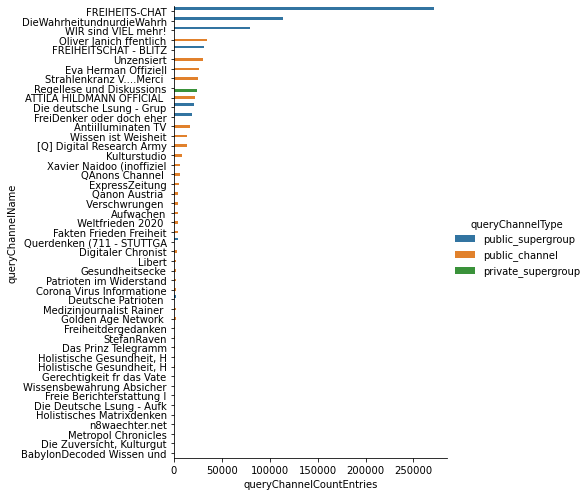

In [34]:
queryPlotter("queryChannelCountEntries")

In [35]:
#queryPlotter("queryChannelPercentRawText")

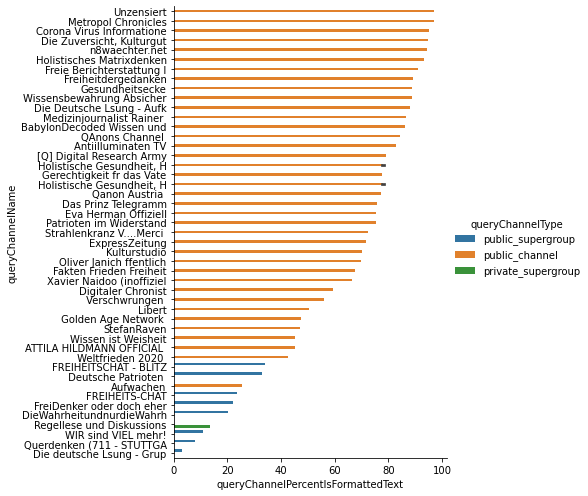

In [36]:
queryPlotter("queryChannelPercentIsFormattedText")

In [37]:
#queryPlotter("queryChannelPercentValidText") 

In [38]:
#queryPlotter("queryChannelPercentPhoto")

In [39]:
#queryPlotter("queryChannelPercentFile")

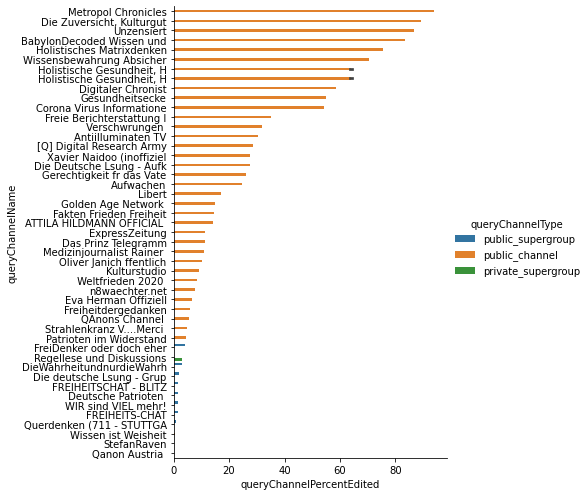

In [40]:
queryPlotter("queryChannelPercentEdited")

## Get valid text

In [41]:
def normalizedValidTextSize(df):
    df = df.copy()
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
    return df[np.abs(df.processedValidTextSize-df.processedValidTextSize.mean()) <= (3*df.processedValidTextSize.std())]

Before all filters		831260
Before normalizedValidTextSize	524609
After normalizedValidTextSize	514091


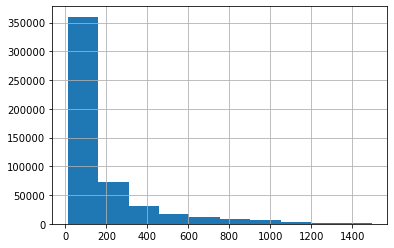

In [42]:
dfMessages = dfAllDataMessages.copy()
print("Before all filters\t\t" + str(len(dfMessages.index)))

dfMessages = dfMessages[dfMessages.processedValidTextSize > 10]
print("Before normalizedValidTextSize\t" + str(len(dfMessages.index)))

dfMessages = normalizedValidTextSize(dfMessages)
print("After normalizedValidTextSize\t" + str(len(dfMessages.index)))

_ = dfMessages.processedValidTextSize.hist()

## Extract Hashtags

In [43]:
def extractImportantHashtags(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.astype(str)["processedTextDataHashtags"] != "[]"]

    hashTagList = list()
    for index, row in dfMessages.iterrows():
        for hashtagItem in row["processedTextDataHashtags"]:
            hashTagList.append(hashtagItem)

    return Counter(hashTagList).most_common(20)

### Public channels

In [44]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-25-janich")

[('#StopLeftDystopia', 96),
 ('#Berlin', 40),
 ('#links', 40),
 ('#Messer', 33),
 ('#Einreise', 32),
 ('#Justiz', 32),
 ('#Kosten', 31),
 ('#Netzfund', 24),
 ('#CoronaKrise', 20),
 ('#Clan', 16),
 ('#Hamburg', 16),
 ('#COVID1984_Lüge', 16),
 ('#Orwell', 15),
 ('#Hannover', 14),
 ('#Corona', 14),
 ('#Freiheit', 13),
 ('#GreatAwakening', 13),
 ('#Psychiatrie', 12),
 ('#QAnon', 12),
 ('#NEONREVOLT', 12)]

In [45]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-25-hildmann")

[('#AHMEMO', 9),
 ('#oneLove', 2),
 ('#ALUHUTSITZT', 1),
 ('#EHRENLOS', 1),
 ('#stayathome', 1),
 ('#Don', 1),
 ('#WiederWHOlungstäter', 1),
 ('#Covid1984_LÜGEN', 1),
 ('#maskeauf', 1),
 ('#BlackLivesMatter', 1),
 ('#STAYATHOME', 1),
 ('#STAYSAFE', 1),
 ('#MASKEAUF', 1),
 ('#VERTRAUTGATES', 1),
 ('#DANKEMERKEL', 1),
 ('#optinfoil', 1),
 ('#Rocker', 1),
 ('#KLARTEXT', 1),
 ('#netzfund', 1),
 ('#Netzfund', 1)]

In [46]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-26-gerechtigkeitVaterland")

[('#Corona', 1), ('#wasistLoxismus', 1), ('#wasistKalergiPlan', 1)]

In [47]:
# TODO LIST

### Public supergroups

In [48]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat")

[('#netzfund', 105),
 ('#Netzfund', 77),
 ('#WWG1WGA', 75),
 ('#killbill', 75),
 ('#ZusammenHalten', 72),
 ('#DieWahrheitWirdSiegen', 68),
 ('#Corona', 66),
 ('#oneLove', 59),
 ('#TEAMHEIMAT', 56),
 ('#Freiheit', 53),
 ('#Berlin', 49),
 ('#Deutschland', 47),
 ('#USA', 46),
 ('#BRD', 44),
 ('#corona', 39),
 ('#wasistLoxismus', 34),
 ('#CoronaKrise', 33),
 ('#wirschaffendas', 32),
 ('#ZSM20', 31),
 ('#Antifa', 30)]

In [50]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-30-deutscheLsg")

[('#Metropolnews', 10),
 ('#BRD', 5),
 ('#N8waechter', 4),
 ('#Wirklichkeit', 4),
 ('#Informationskrieg', 4),
 ('#Die_deutsche_Lösung', 4),
 ('#Berlin', 4),
 ('#Corona', 3),
 ('#VOTING', 2),
 ('#Währungssystem', 2),
 ('#Finanzsystem', 2),
 ('#Steuern', 2),
 ('#Arbeitslosigkeit', 2),
 ('#Wirtschaft', 2),
 ('#Renten', 2),
 ('#Absicherung', 2),
 ('#Polizei', 2),
 ('#Versammlungsfreiheit', 2),
 ('#ModerneMärchen', 2),
 ('#Krone', 2)]

In [51]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-10-01-deutschePatri")

[('#netzfund', 3),
 ('#Corona', 2),
 ('#BerlinDemo', 2),
 ('#Berlin', 2),
 ('#TagDerFreiheit', 2),
 ('#ÖRR', 2),
 ('#ZDF', 2),
 ('#Lügenpresse', 2),
 ('#weltweiten', 1),
 ('#IQ', 1),
 ('#Unterschiede', 1),
 ('#Wissenschaftlicher', 1),
 ('#Vortrag', 1),
 ('#Lehrer', 1),
 ('#Dr', 1),
 ('#Specht', 1),
 ('#Political', 1),
 ('#Correctness', 1),
 ('#YOUTUBESTREIK', 1),
 ('#VAXXED', 1)]

In [52]:
# TODO LIST

## Extract Urls

In [53]:
def extractImportantUrls(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.astype(str)["processedTextDataURLs"] != "[]"]

    urlList = list()
    for index, row in dfMessages.iterrows():
        for urlItem in row["processedTextDataURLs"]:
            urlData = urlparse(str(urlItem))
            hostname = urlData.hostname
            urlList.append(hostname)

    return Counter(urlList).most_common(20)

### Public channels

In [54]:
extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-25-janich")

[('www.youtube.com', 2320),
 ('www.journalistenwatch.com', 1585),
 ('youtu.be', 1558),
 ('twitter.com', 1529),
 ('www.bild.de', 1004),
 ('www.welt.de', 952),
 ('www.focus.de', 922),
 ('t.me', 857),
 ('t.co', 809),
 ('www.epochtimes.de', 765),
 ('19vierundachtzig.com', 516),
 (None, 416),
 ('focus.de', 410),
 ('www.n-tv.de', 387),
 ('jungefreiheit.de', 385),
 ('www.spiegel.de', 383),
 ('deutsch.rt.com', 266),
 ('www.faz.net', 253),
 ('www.tagesschau.de', 246),
 ('www.tichyseinblick.de', 219)]

In [55]:
extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-25-hildmann")

[('youtu.be', 1413),
 ('www.youtube.com', 380),
 ('t.me', 355),
 ('www.bitchute.com', 174),
 (None, 142),
 ('bit.ly', 135),
 ('www.spiegel.de', 120),
 ('www.welt.de', 114),
 ('amzn.to', 104),
 ('de.m.wikipedia.org', 76),
 ('www.instagram.com', 72),
 ('www.n-tv.de', 66),
 ('www.t-online.de', 54),
 ('www.tagesschau.de', 52),
 ('de.wikipedia.org', 51),
 ('twitter.com', 46),
 ('www.zeit.de', 46),
 ('www.rnd.de', 42),
 ('www.bild.de', 38),
 ('www.facebook.com', 36)]

In [56]:
extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-26-gerechtigkeitVaterland")

[('youtu.be', 17),
 ('t.me', 16),
 ('www.youtube.com', 11),
 ('www.bitchute.com', 5),
 ('donnersender.ru', 4),
 (None, 3),
 ('fliegende-wahrheit.com', 2),
 ('deutsche-wirtschafts-nachrichten.de', 2),
 ('www.kla.tv', 1),
 ('www.intelligencesquared.com', 1),
 ('www.zdf.de', 1),
 ('twitter.com', 1),
 ('alionstrail.com', 1),
 ('www.facebook.com', 1),
 ('www.dasgelbeforum.net', 1),
 ('www.wallstreet-online.de', 1),
 ('worldnews123.one', 1),
 ('www.tagesschau.de', 1),
 ('www.spiegel.de', 1),
 ('www.rki.de', 1)]

In [57]:
extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo")

[('t.me', 2136),
 ('www.youtube.com', 418),
 ('www.journalistenwatch.com', 105),
 ('uncut-news.ch', 91),
 ('bit.ly', 87),
 ('www.heise.de', 60),
 ('de.sputniknews.com', 52),
 ('www.t-online.de', 39),
 ('www.focus.de', 37),
 ('youtu.be', 36),
 ('www.mmnews.de', 28),
 ('www.freiewelt.net', 23),
 ('www.merkur.de', 20),
 ('www.bild.de', 19),
 ('donnersender.ru', 19),
 ('corona-ausschuss.de', 19),
 ('www.pravda-tv.com', 18),
 ('www.nachdenkseiten.de', 18),
 ('www.faz.net', 18),
 ('opposition24.com', 16)]

In [58]:
# TODO LIST

### Public supergroups

In [59]:
extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat")

[('youtu.be', 16551),
 ('www.youtube.com', 7691),
 ('t.me', 6317),
 (None, 3775),
 ('m.youtube.com', 1113),
 ('www.facebook.com', 1061),
 ('twitter.com', 940),
 ('de.metapedia.org', 647),
 ('www.bitchute.com', 562),
 ('archive.is', 363),
 ('www.welt.de', 340),
 ('m.facebook.com', 338),
 ('www.instagram.com', 327),
 ('telegra.ph', 318),
 ('bit.ly', 302),
 ('www.amazon.de', 289),
 ('www.n-tv.de', 267),
 ('de.m.wikipedia.org', 250),
 ('www.spiegel.de', 248),
 ('www.bild.de', 248)]

In [60]:
extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-30-deutscheLsg")

[(None, 105),
 ('t.me', 78),
 ('de.wikipedia.org', 43),
 ('www.n8waechter.net', 23),
 ('www.metropolnews.info', 11),
 ('die-heimkehr.info', 7),
 ('youtu.be', 6),
 ('de.metapedia.org', 4),
 ('paypal.me', 4),
 ('www.youtube.com', 3),
 ('www.dw.com', 3),
 ('www.jura.uni-wuerzburg.de', 3),
 ('en.wikipedia.org', 2),
 ('russische-botschaft.ru', 2),
 ('christ-michael.net', 2),
 ('qmap.pub', 2),
 ('www.n-tv.de', 2),
 ('www.cia.gov', 2),
 ('de.statista.com', 2),
 ('www.schreibwerkstatt.co.at', 2)]

In [61]:
extractImportantUrls("DS-08-10-2020/ChatExport_2020-10-01-deutschePatri")

[('youtu.be', 334),
 ('twitter.com', 80),
 ('www.youtube.com', 51),
 ('t.me', 26),
 (None, 18),
 ('www.amazon.de', 16),
 ('www.bitchute.com', 12),
 ('dein.tube', 12),
 ('www.reitschuster.de', 9),
 ('de.metapedia.org', 7),
 ('www.anti-spiegel.ru', 6),
 ('invidio.us', 6),
 ('www.patriotpetition.org', 6),
 ('m.youtube.com', 6),
 ('www.epochtimes.de', 5),
 ('www.tichyseinblick.de', 5),
 ('www.facebook.com', 4),
 ('pressecop24.com', 4),
 ('tinyurl.com', 4),
 ('deutsch.rt.com', 3)]

In [62]:
# TODO LIST

## Word Clouds

In [82]:
#TODO Difference capital letters?
#TODO Context?

# Use "global" for all DataFrames
def plotChannelWordCloud(filePath, label, filterList):
    timeStart = time.time()
    
    if(filePath != "global"):
        dfMessages = dictMessages[filePath].copy()
    else:
        dfMessages = dfAllDataMessages.copy()
    
    print("[Start transform text to global text string]")
    textList = []
    for index, row in dfMessages.iterrows():
        textList.append(" " + row["processedValidText"])
        
    textString = ''.join(textList)
    
    germanStopWordsList = nltk.corpus.stopwords.words('german')
    germanStopWordsList.append("http")
    germanStopWordsList.append("https")
    germanStopWordsList.append("ja") #TODO: split to local - maybe?
    germanStopWordsList.append("mehr")
    germanStopWordsList.append("mal")
    germanStopWordsList.append("schon")
    germanStopWordsList.append("immer")
    germanStopWordsList.append("wurde")
    germanStopWordsList.append("wurden")
    germanStopWordsList.append("sei")
    germanStopWordsList.append("sein")
    germanStopWordsList.append("viel")
    germanStopWordsList.append("viele")
    germanStopWordsList.append("wegen")
    germanStopWordsList.append("müssen")
    germanStopWordsList.append("geht")
    germanStopWordsList.append("gibt")
    germanStopWordsList.append("wer")
    germanStopWordsList.append("wie")
    germanStopWordsList.append("was")
    germanStopWordsList.append("macht")
    germanStopWordsList.append("machen")
    germanStopWordsList.append("machte")
    germanStopWordsList.append("kommen")
    germanStopWordsList.append("kommt")
    germanStopWordsList.append("glaube")
    germanStopWordsList.append("glaubst")
    germanStopWordsList.append("tun")
    germanStopWordsList.append("wäre")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sagten")
    germanStopWordsList.append("hat")
    germanStopWordsList.append("hast")
    germanStopWordsList.append("haben")
    germanStopWordsList.append("habt")
    germanStopWordsList.append("statt")
    germanStopWordsList.append("genau")
    germanStopWordsList.append("sagen")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sagten")
    germanStopWordsList.append("bitte")
    germanStopWordsList.append("bitten")
    germanStopWordsList.append("danke")
    germanStopWordsList.append("dank")
    germanStopWordsList.append("sollen")
    germanStopWordsList.append("soll")
    germanStopWordsList.append("sollte")
    germanStopWordsList.append("sehen")
    germanStopWordsList.append("seht")
    germanStopWordsList.append("zeigen")
    germanStopWordsList.append("zeigt")
    germanStopWordsList.append("seid")
    germanStopWordsList.append("seit")
    
    for fItem in filterList:
        germanStopWordsList.append(fItem)
    
    print("[Start generate wordCloud]")
    wordcloud = WordCloud(
                background_color="black",
                width=1920,
                height=1080,
                stopwords=germanStopWordsList
            ).generate(textString)
    wordcloud.to_file("wordcloud-" + label + ".png")
    
    print("Top 20 occ:\n" + str(pd.Series(wordcloud.words_).head(20)))
    
    print("[Start generate figure]")
    plt.figure(figsize=(14, 14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    
    timeEnd = time.time()
    print("[Finished]")
    print('{:5.3f}s'.format(timeEnd-timeStart))

### Public channels

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Deutschland    1.000000
Menschen       0.777668
Video          0.765316
Polizei        0.595356
bereit         0.540020
Berlin         0.465909
Corona         0.420455
Prozent        0.414032
neue           0.398715
AfD            0.389822
laut           0.388834
dabei          0.381423
Fall           0.371047
Welt           0.368577
and            0.368577
sagt           0.367589
Kinder         0.364625
a              0.362154
heute          0.355731
deutschen      0.354249
dtype: float64
[Start generate figure]


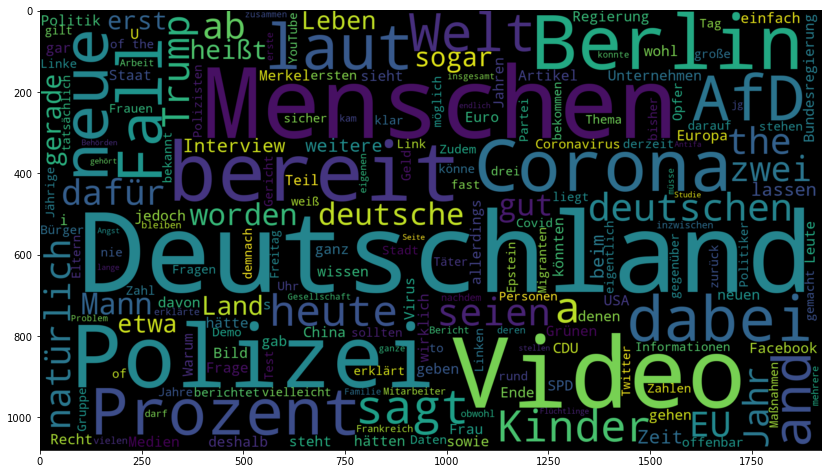

[Finished]
13.296s


In [83]:
# Oliver Janich öffentlich (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-janich",
    "pc-janich",
    []
)

In [ ]:
# ATTILA HILDMANN OFFICIAL (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-hildmann",
    "pc-hildmann",
    ["ATTILAHILDMANN CHAT"]
)

[Start transform text to global text string]
[Start generate wordCloud]


In [ ]:
# Gerechtigkeit für das Vaterland (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-26-gerechtigkeitVaterland",
    "pc-GerechtigkeitfuerdasVaterland",
    ["gerechtigkeitfuersvaterland"]
)

In [ ]:
# Corona Virus Informationen (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo",
    "pc-cVirusInfo",
    [])

In [ ]:
# Liberté (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-26-liberte",
    "pc-liberte",
    []
)

In [ ]:
# TODO LIST

In [ ]:
# Eva Herman Offiziell (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-27-evaherman",
    "pc-evaHerman",
    []
)

In [ ]:
# Xavier Naidoo (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-xavier",
    "pc-xavier",
    ["xavier_naidoo", "Xavier_Naidoo", "politische_bildersprueche", "einmal_hin_alles_drin"]
)

In [ ]:
# TODO LIST

### Public supergroups

In [ ]:
# FREIHEITS-CHAT (public_supergroup)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat",
    "ps-freiheitsChat",
    []
)

In [ ]:
# Die deutsche Lösung - Gruppe (public_supergroup)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-30-deutscheLsg",
    "ps-DieDeutscheLoseungGruppe",
    []
)

In [ ]:
# Deutsche Patrioten (public_supergroup)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-10-01-deutschePatri",
    "ps-deutschePatrioten",
    []
)

In [ ]:
# FREIHEITSCHAT - BLITZ (public_supergroup)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-10-01-freiheitsChatBlitz",
    "ps-freiheitsChatBlitz",
    []
)

In [ ]:
# DieWahrheitundnurdieWahrheit (public_supergroup)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-10-02-chatDieWahrheit",
    "ps-DieWahrheitundnurdieWahrheit",
    []
)

In [ ]:
# TODO LIST

In [ ]:
plotChannelWordCloud(
    "global",
    "global",
    []
)

## Concordance

In [ ]:
#t = nltk.text.Text("Hallo Welt. Was machst du gerade? Das ist nur ein Test! Schöne Welt! Das geht ja gar nicht Welt!")